Here I give an example of calculating the band basis mass enhancement in a care where DMFT is done with a Hubbard model defined via Wannier90. 

This is done for the nickelate NdNiO2 in a case with 13 Wannier functions but only the first 2 are treated as correlated

As a first step, I calculate the Wannier H(k) along a high symmetry $k$ path. This is useful to have for other postprocessing calculations, like finding momentum resolved spectral functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from h5 import HDFArchive
from triqs.gf import *

In [4]:
# construct k points array
kpoints = []
for i in range(32):
    kpoints.append([i/62., 0., 0.]) #Gamma to X
for i in range(1,32):
    kpoints.append([.5, i/62., 0.]) #X to M
for i in range(43, -1, -1):
    kpoints.append([i/88., i/88., 0.])#M to Gamma
for i in range(1,38):
    kpoints.append([0., 0., i/74.])# Gamma to Z
for i in range(1,32):
    kpoints.append([i/62., 0., 0.5]) #Z to R
for i in range(1, 32):
    kpoints.append([.5, i/62., .5]) #R to A
for i in range(43, -1, -1):
    kpoints.append([i/88., i/88., .5]) #A to Z
kpoints = np.asarray(kpoints)
nk = len(kpoints)

# construct Wannier H(R-R') in an array
mx = 10 #maximum hopping cell in x direction
my = 10
mz = 10
nwan = 13 #number of wannier functions
skip = 621 #header rows to skip
nx = 2*mx+1
ny = 2*my+1
nz = 2*mz+1

hr = np.loadtxt('NdNiO2_mlwf_13_hr.dat', skiprows = skip) #load file with Wannier Hamiltonian
Hrij = np.zeros((nx,ny,nz,nwan,nwan), dtype = np.complex_)
for line in hr:
    rxind = int(line[0]) + mx
    ryind = int(line[1]) + my
    rzind = int(line[2]) + mz
    i = int(line[3]) - 1
    j = int(line[4]) - 1
    Hrij[rxind,ryind,rzind,i,j] = line[5] + 1j*line[6]
del hr

Hk = np.zeros((nk, nwan, nwan), dtype=np.complex_)
#loop over k points
for ik, k in enumerate(kpoints):
    
    #find H(k) for given k point by fourier transforming H(R-R')
    Hexp = np.empty_like(Hrij,dtype = np.complex_)
    for xi in range(nx):
        for yi in range(ny):
            for zi in range(nz):
                r = (xi-mx, yi-my, zi-mz)
                eikr = np.exp(-1j*2*np.pi*k.dot(r))
                Hexp[xi, yi, zi, :, :] = eikr
    Hkrij = Hrij * Hexp
    Hk[ik] = np.sum(Hkrij, axis = (0,1,2))


Now load the orbital basis self energy and use H(k) to transform it to the band basis

In [9]:
with HDFArchive('NdNiO2_mlwf_Sigma.h5','r') as A:
    Sigma = A['Sigma_iw']
    dc = A['dc']
    mu = A['mu']

sorb = np.zeros((6, nwan, nwan), dtype = np.complex_) #orbital self energy matrix for first 6 Matsubara points
for i in range(2):
    sorb[:,i,i] = Sigma['up_%d'%i].data[1025:1031,0,0] - dc - mu
omega = [i.imag for i in Sigma.mesh][1025:1032]

mass_enhancements = np.zeros((nk, nwan))
npoints = 6
order = 4
for ik in range(nk):
    hk = Hk[ik]
    evals, evecs = np.linalg.eigh(hk)
    sband = np.zeros_like(sorb)
    for w  in range(6):
        sband[w,:,:] = evecs.conj().T.dot(sorb[w,:,:]).dot(evecs)
    for i in range(13):
        lt = np.polyfit(omega[:npoints], sband[:npoints, i, i].imag, order)[-2]
        mass_enhancements[ik,i] = 1 - lt

In [11]:
#construct Wannier bands from eigenvalues of H(k)
wanbands = np.zeros((nk,nwan))
for ik in range(nk):
    wanbands[ik] = np.linalg.eigvalsh(Hk[ik])

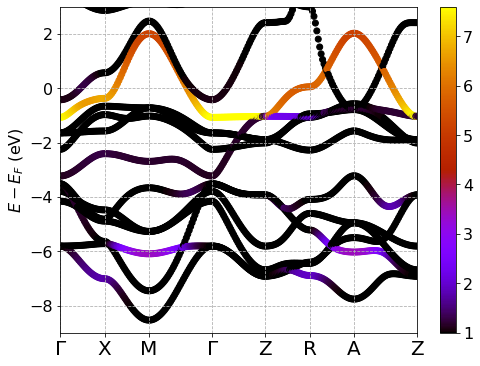

In [17]:
plt.figure(figsize=(8,6))
plt.rc('font', size=16)

ks = range(nk)
kp = []
for k in ks:
    for i in range(nwan):
        kp.append(k)     

Ef = 14.4592 #Quantum Espresso Fermi energy in this specific case
E = wanbands.reshape(nk*nwan) - Ef
plt.scatter(kp, E, c = mass_enhancements.reshape(nk*nwan), cmap = 'gnuplot')
plt.xlim(0,nk-1)
plt.ylim(-9,3) 
plt.grid(ls = '--')
plt.ylabel('$E - E_F$ (eV)')
plt.xticks([0,31, 62, 106, 143, 174, 205, 249], ['$\Gamma$', 'X', 'M', '$\Gamma$', 'Z', 'R', 'A', 'Z'], fontsize = 20)
plt.colorbar()
plt.show()